In this notebook we will show how the functions we defined in `utils.py` work on the frist train image (`train_00`) and how they are used to make the predictions. If you need more in depth descriptions, in `utils.py` you find all the functions well commented.

### Imports

In [16]:
# !pip install treys
# !pip install termcolor
# !pip install pandas

In [17]:
from typing import List, Union
import os
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

In [18]:
from scipy.fft import fft
from scipy.interpolate import interp1d

In [19]:
import skimage
from skimage.transform import rotate, resize
from skimage.morphology import binary_erosion, dilation, opening, closing, disk, binary_closing
from skimage.color import rgb2gray, rgb2hsv
from skimage.filters import median, gaussian
from skimage.measure import find_contours
from skimage.exposure import match_histograms
import skimage.exposure as e

In [20]:
from IPython.display import Image, display, clear_output

In [21]:
import cv2
import PIL.Image

In [22]:
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [23]:
from utils_finals import *

### Example of functioning

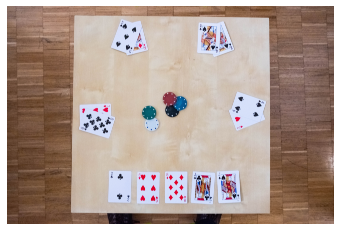

In [24]:
path_data = "data/train"
img_name = "train_00"

file = os.path.join(path_data, img_name+".jpg")
im = skimage.io.imread(file)
plt.imshow(im)
plt.axis("off")
plt.show()

We start using our functions `plot` and `corners` to get the four corners of the table.

In [25]:
hull, edges, contours = plot(im)
#here we shift up the corners as the image have been expanded in the "plot" function (see in utils.py for more details)
corn = corners(hull, im) - np.tile(np.array([0,100]), (4, 1)) 
corn

array([[4778,  248],
       [4793, 3773],
       [1209, 3767],
       [1274,  205]])

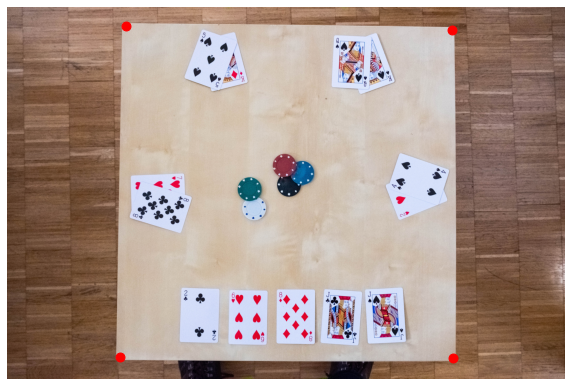

In [26]:
fig, axs = plt.subplots(1 ,figsize=(10,10))
plt.scatter(corn[:,0], corn[:,1], s =80, c = "red")
plt.imshow(im)
plt.axis('off')
plt.show()

Now, that we have identified the table, we can crop it and move forward. Using the function `deskew`, the table will be cut and deskewed in order to have a better analysis (Pay attention that the function `deskew` already does all the steps above, so it take the image as input).

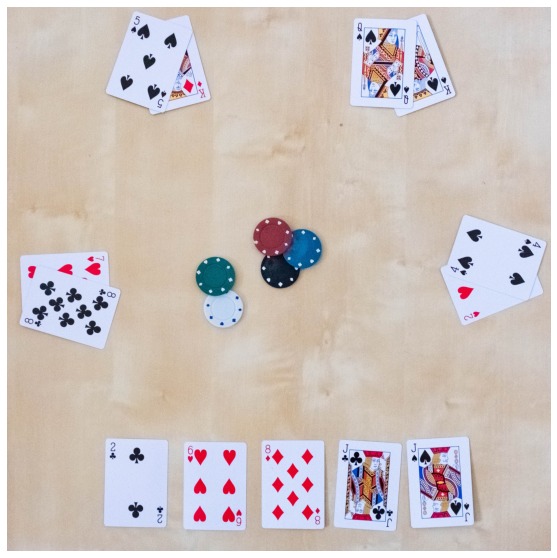

In [27]:
fig, axs = plt.subplots(1 ,figsize=(10,10))
deskewed = deskew(im)
plt.imshow(deskewed)
plt.axis('off')
plt.show()

Now the next step is dividing the table in the areas containig the player cards, the table cards, and the fiches using the function `area_partition`.

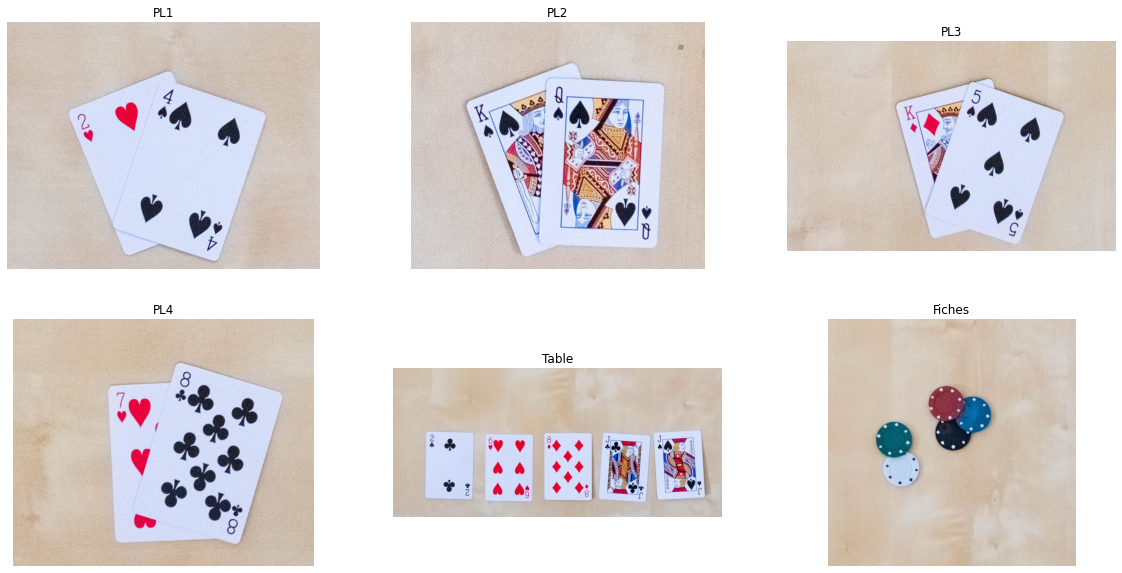

In [28]:
[pl1, pl2, pl3, pl4, table, fiches] = area_partition(deskewed)
all_items = [pl1, pl2, pl3, pl4, table, fiches]
fig, axs = plt.subplots(2, 3 ,figsize=(20,10))
positions = ["PL1", "PL2", "PL3", "PL4", "Table", "Fiches"]
for i in range(6):
    row = i//3
    col = i%3
    axs[row, col].imshow(all_items[i])
    axs[row, col].axis("off")
    axs[row, col].set_title(positions[i])

### Counting the fiches

To count the fiches we only need to pass the cropped fiches image in hsv color space to the function `count_fiches`. The function will return a dictionary with the number of fiches per color, and as you can see it preditcs them correctly.

In [29]:
count_fiches(fiches)

FileNotFoundError: [Errno 2] No such file or directory: 'mean_saturation.npy'

### Cassifying cards

To classify the cards in number and suit, we follow three steps. First, we attempt to outline each card. For the players' cards, this involves outlining _both_ cards together, since these cards are overlapping. For the table cards, we attempt to outline each card separately. After each card is outlined, we try to find a precise a cutout as possible of the card number and suit. From here, we compare the each number and suit to a "ground truth" copy to classify each cutoout. 

We start by separating the table cards and performing an RGB to HSV transform on all the separate pieces. We use the color saturation to detect an outsized presence of red and blue in each card, to check if a player is absent. Each separated image and its saturation are plotted below:

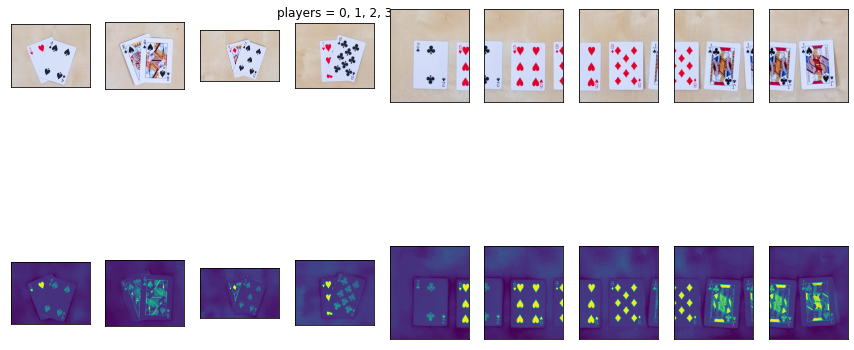

In [30]:
imgs, hsv_imgs = load_and_process_full_image(im, make_plot=False)
players, imgs, h_imgs = get_players_and_imgs(hsv_imgs, imgs)

Next, we transform the saturation into a binary image. For each image, we do this in an iterative fashion. We start with a low threshold for the binary transformation. Then, we attempt to outline the cards. If a suitable outline has been found, we return the contour. If not, we attempt several dilations in a row, checking between each if a suitable contour can be found. If a suitable contour is not found, we make a new binary image where we increase the threshold slightly. We continue in this fashion until a suitable contour is found.

By "suitable" contour, we mean a contour that convincingly outlines one card (in the case of the table cards) or two overlapping cards (in the case of the players' cards). Employ the following "checks":

+ The contour should not be too long nor too short. These values are hard-coded.
+ The contour should approximately encircle the center of the photo. We check this by seeing if the polygon created by the contour contains at least a few of a cluster of points in the center of the image.

Once one or more suitable contours has been found, we find the corners of the cards. In the case of the player's cards, the corners should be the top and bottom of the outside edges of both cards (see the plot below). In the case of the table cards, the corners are simply the four corners of the cards.

To find the corners, we search for an approximation of the contour that has only four points. For this, we use `cv2.approxPolyDP`. Once found, we use the corners to perform additional checks on the contour:

+ The leftmost and rightmost corners should have a distance of roughly 625 pixels between them. This is the length of the long edge of a card.
+ No corners should be touching the top or sides of a photo. (They may touch the bottom of a photo, in the case that the card is hanging slightly off the edge of the table.)

Finally, the individual cards in each players' hand must be outlined. To do this, we separate the left and right hand points. For the left hand points, we find the angle between the points, and draw a perpendicular line to this angle about 450 pixels to the right of the points. For the right points we do the same, however, we draw the new points leftwards. The new sets of points become rectangles that approximately outline each card.

The process is illustrated for each cutout below:

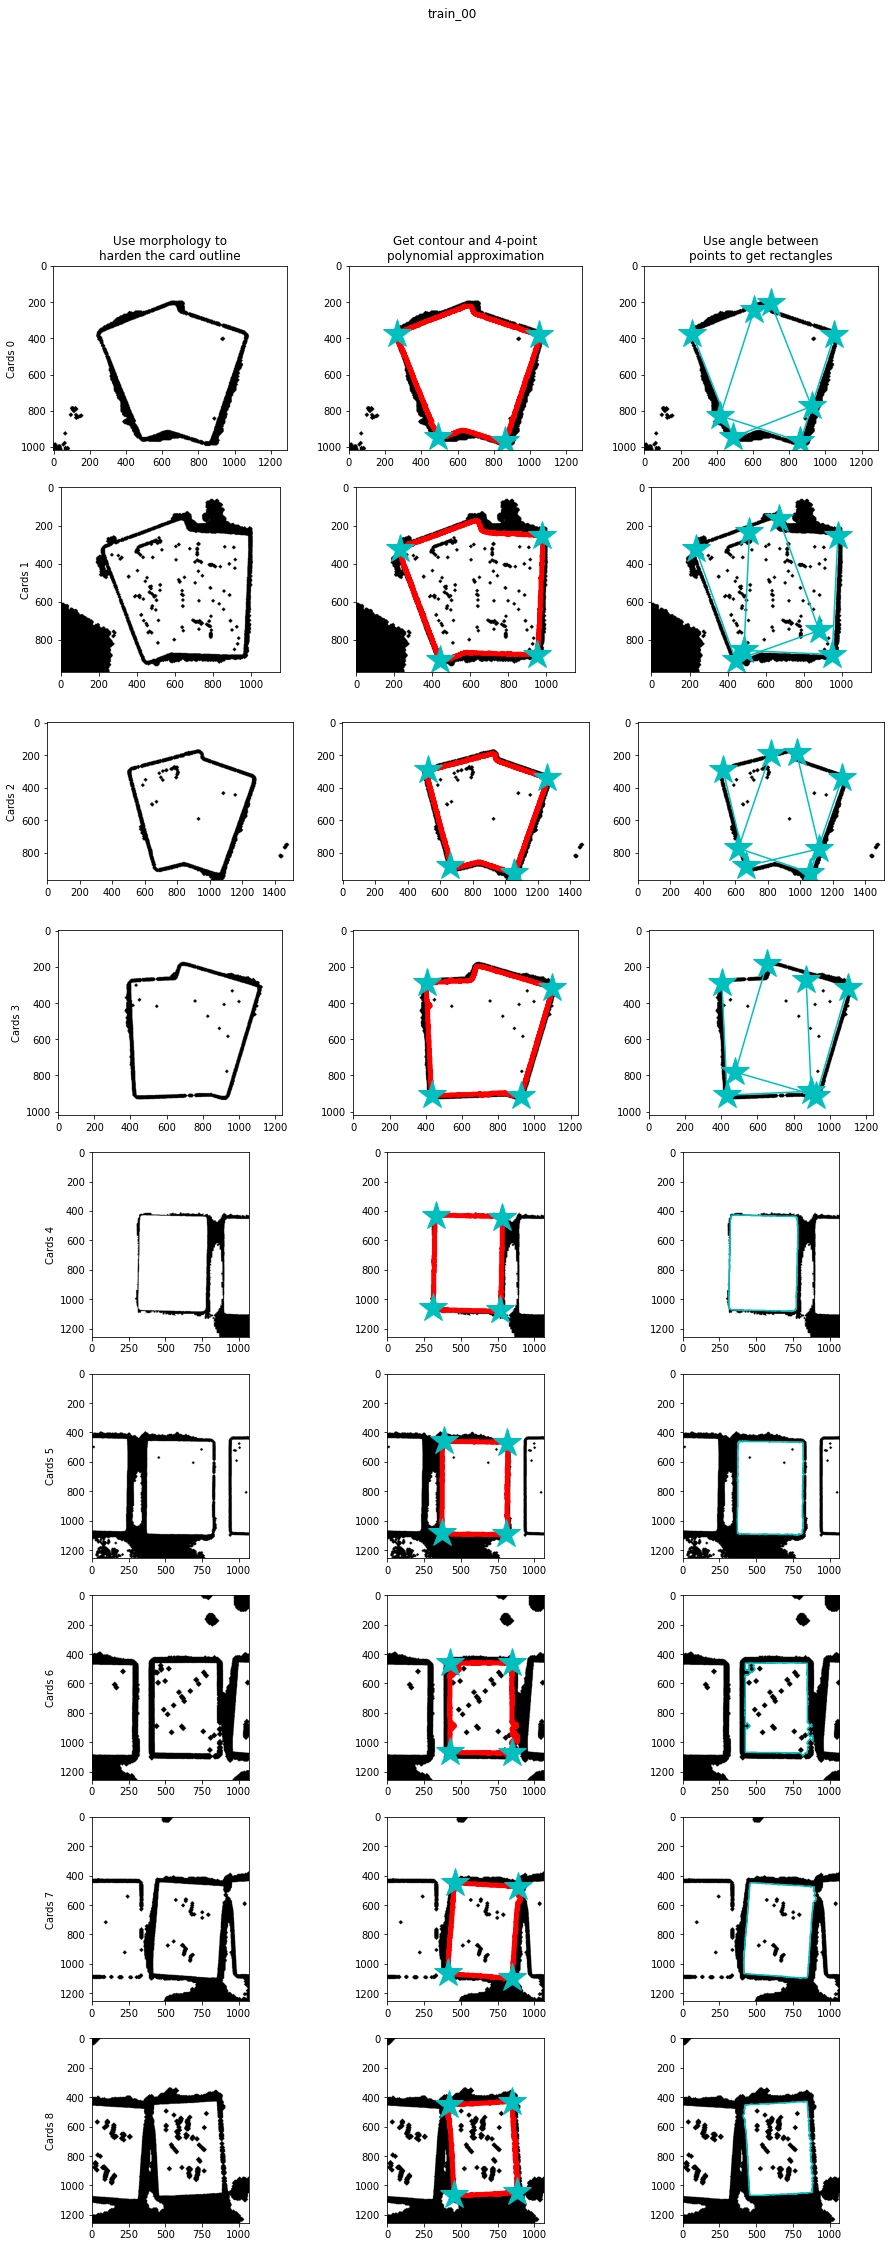

In [31]:
card_outlines = segment_cards(imgs, 'train_00', h_imgs, make_plot=True)

Now that we've segmented each card, we cut the card out of the main image. We then rotate the card and cut out the upper left corner. From here, we attempt to separate the number and the suit from the upper-left corner. We start by finding the right and left hand sides of the number (cyan dotted lines below). We do this by tracking from the upper-right edge of the cutout (red and green lines below). In the magenta area, we check for any black pixels. When we find them, we know we've reached the number. 

Once we've found the sides of the number, we find the tops and bottoms of the number and suit, respectively. Finally, we cut out the found number and suit and overlay each "ground truth" number and suit over the cutouts. The most similar "ground truth" is used for classification.

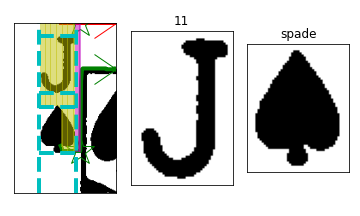

In [34]:
with open('numbers.pickle', 'rb') as handle:
    real_numbers = pickle.load(handle)

with open('suits.pickle', 'rb') as handle:
    real_suits = pickle.load(handle)

numbers, suits = get_numbers_and_suits(card_outlines, imgs, real_numbers, real_suits, make_plot=True)